at first, joint prediction
- [ ] two nets for class and contexts
- [ ] the last layer for class and contexts
- [ ] and both can add attention

In [1]:
import gc, argparse, sys, os, errno
from functools import reduce
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import scipy
import sklearn
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')
from bokeh.io import output_notebook, show
output_notebook()
from scipy import io
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from bokeh.palettes import Category20c
from ipywidgets import interact,interactive, FloatSlider,IntSlider, RadioButtons,Dropdown,Tab,Text

from collections import defaultdict
from sklearn.datasets import make_classification, make_regression, make_circles, make_moons, make_gaussian_quantiles
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, precision_score, \
    roc_curve, precision_recall_curve, average_precision_score, matthews_corrcoef, confusion_matrix
from statsmodels.robust.scale import mad
from scipy.stats import pearsonr

random_state = np.random.RandomState(1289237)  
from sklearn.preprocessing import OneHotEncoder
import torch # package for building functions with learnable parameters
import torch.nn as nn # prebuilt functions specific to neural networks
import torch.utils.data
from torch.autograd import Variable # storing data while learning
from scipy import stats
from sklearn.model_selection import train_test_split
from torch import optim
from torch.utils import data as utilsdata
import torch.nn.functional as F

Populating the interactive namespace from numpy and matplotlib


Loading BokehJS ...

In [2]:
cd ~/projects/DIP

/home/chenxupeng/projects/DIP


In [3]:
#setup figure template
figure_template_path = 'bin'
if figure_template_path not in sys.path:
    sys.path.append(figure_template_path)
from importlib import reload
import figure_template
#force reload of the module
reload(figure_template)
from figure_template import display_dataframe, embed_pdf_figure, embed_pdf_pages,std_plot,legendhandle

In [47]:
def prepare_dataset(datafile='data/BoW_Training.mat',valid_method = 'classic',train_context_num=5):
    import scipy.io as sio
    BoW_Training = sio.loadmat(datafile)['data']
    print (BoW_Training.shape)
    BoW_Training_x = BoW_Training[:,:50]
    BoW_Training_y = BoW_Training[:,-2:]
    if valid_method == 'classic':
        return train_test_split(BoW_Training_x, BoW_Training_y, test_size=0.2, random_state=42)
    elif valid_method =='non-iid':
        '''
        split the dataset so for each class, split 7 contexts into 5:2, 
        predict 2 contexts corresponding class
        '''
        tmp_select_ind = np.array([]).astype('int')
        for i in np.unique(BoW_Training_y[:,0]):
            #print (np.unique(BoW_Training_y[:,1][BoW_Training_y[:,0] ==i]))
            tmp_context_ind = np.random.choice(np.unique(BoW_Training_y[:,1][BoW_Training_y[:,0] ==i]),
                             train_context_num,replace=False,)
            tmp_select_ind = np.concatenate((tmp_select_ind,np.where( (BoW_Training_y[:,0]==i)& 
                                (np.isin(BoW_Training_y[:,1],tmp_context_ind )==1) )[0]  ))

        train_ind = tmp_select_ind
        test_ind = np.setdiff1d(np.arange(0,BoW_Training_y.shape[0]),tmp_select_ind)
        enc = OneHotEncoder(handle_unknown='ignore')
        y_class = enc.fit_transform(BoW_Training_y[:,0].reshape(-1,1)).toarray()
        y_context = enc.fit_transform(BoW_Training_y[:,1].reshape(-1,1)).toarray()
        y = np.concatenate((y_class,y_context),axis=1)
        BoW_Training_x = preprocess(BoW_Training_x,method='zscore')[0]
        return BoW_Training_x[train_ind],BoW_Training_x[test_ind],y[train_ind],\
                y[test_ind],train_ind,test_ind
def preprocess(data,method='minmax'):
    if method =='minmax':
        scaler = MinMaxScaler()
        scaler.fit(data)
    elif method =='zscore':
        scaler = StandardScaler()
        scaler.fit(data)
    elif method =='robust':
        scaler = RobustScaler()
        scaler.fit(data)
    return scaler.transform(data),scaler

X_train, X_test, y_train, y_test,_,_ = prepare_dataset(datafile='data/BoW_Training.mat',
                                                        valid_method = 'non-iid',
                                                         train_context_num=5)
print('number of training samples: {}, test samples: {}'.format(X_train.shape[0], X_test.shape[0]))


(4156, 52)
number of training samples: 2976, test samples: 1180


In [48]:
y_train.shape

(2976, 20)

# two nets for context and class

In [104]:
class seperate_NN(torch.nn.Module):

    def __init__(self,n_feature,n_hidden,n_label):
        super(seperate_NN,self).__init__()
        self.net1 = torch.nn.Sequential(
            nn.Linear(n_feature,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,n_label)            
        )
        self.net2 = torch.nn.Sequential(
            nn.Linear(n_feature,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,n_label)            
        )

    def forward(self,x):    # (-1,n_feature)
        y1 = self.net1(x)               
        y2 = self.net2(x)
        return y1,y2 #no need to do softmax, cross entropy will do it!
    #torch.nn.functional.softmax(y1),torch.nn.functional.softmax(y2)

use_cuda = False
model =  seperate_NN(50,20,10)
if use_cuda:
    model = model.cuda()

In [132]:
for batch_idx, (data, target) in enumerate(train_loader):
    images,label = data, target

In [106]:
LEARNING_RATES = [0.01]
MOMENTUM_RATES = [.9]
WEIGHT_DECAY_RATES = [.005]
batch_size = 20
PLOT = 1
EPOCHS = 400
# Dataloader

train_data = utilsdata.TensorDataset(torch.from_numpy(X_train.astype('float32')), torch.from_numpy(y_train.astype('int')))
test_data = utilsdata.TensorDataset(torch.from_numpy(X_test.astype('float32')), torch.from_numpy(y_test.astype('int')))
train_loader = torch.utils.data.DataLoader(
                                           dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(
                                          dataset=test_data,
                                          batch_size=batch_size,
                                          shuffle=False)


In [111]:
def train(epoch, model, train_loader, optimizer, log_interval=100, cuda=None,report=False):
    model.train()
    correct1 = 0
    correct2 = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        target1 = target[:,:10]
        target2 = target[:,10:]
        data, target1, target2 = Variable(data), Variable(target1), Variable(target2)
        optimizer.zero_grad()
        output1, output2 = model(data) #return y1 and y2 for class and context

        pred1 = output1.data.max(1)[1] # get the index of the max log-probability
        pred2 = output2.data.max(1)[1]
        #print (output.data,output.data.max(1),output.data.size(),target.data.size())
        #print (target2)
        #print (pred2.eq(target2.data.max(1)[1]).cpu().sum())
        correct1 += pred1.eq(target1.data.max(1)[1]).cpu().sum()
        correct2 += pred2.eq(target2.data.max(1)[1]).cpu().sum()
        accuracy1 =  float(correct1) / float(len(train_loader.dataset))
        accuracy2 =  float(correct2) / float(len(train_loader.dataset))
        #print (output1.max(1)[1],target1.max(1)[1])
        loss = torch.nn.functional.cross_entropy(output1, target1.max(1)[1]) +torch.nn.functional.cross_entropy(output2, target2.max(1)[1])
        loss.backward()
        #print (loss,loss.data)
        optimizer.step()
        if batch_idx % log_interval == 0:
            if report ==1:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} Accuracy: ({:.4f})\n'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.data.item(), accuracy1))

def validate(loss_vector, accuracy_vector, model, validation_loader, cuda=None,report=False):
    model.eval()
    val_loss, correct1,correct2 = 0, 0,0
    for data, target in validation_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        target1 = target[:,:10]
        target2 = target[:,10:]
        data, target1, target2 = Variable(data, volatile=True), Variable(target1), Variable(target2)
        output1, output2 = model(data)
        val_loss += torch.nn.functional.cross_entropy(output1, target1.max(1)[1]).item()+torch.nn.functional.cross_entropy(output2, target2.max(1)[1]).item()
        pred1 = output1.data.max(1)[1] # get the index of the max log-probability
        pred2 = output2.data.max(1)[1]
        #correct += pred.eq(target.data).cpu().sum()
        #print (pred1,target1)
        correct1 += pred1.eq(target1.data.max(1)[1]).cpu().sum()
        correct2 += pred2.eq(target2.data.max(1)[1]).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy1 = float(correct1) / float( len(validation_loader.dataset) )
    accuracy2 = float(correct2) / float( len(validation_loader.dataset) )
    accuracy_vector.append(accuracy1)
    if report ==1:
        print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f})\n'.format(
            val_loss, correct1, len(validation_loader.dataset), accuracy1))
def main(train_loader,validation_loader,LEARNING_RATES , MOMENTUM_RATES ,WEIGHT_DECAY_RATES,report_interval):
    cuda = torch.cuda.is_available()
    print('Using PyTorch version:', torch.__version__, 'CUDA:', cuda)



    for i in tqdm(range(1, len(LEARNING_RATES) + 1)):
        if cuda:
            model.cuda()
        optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATES[0],momentum=MOMENTUM_RATES[0],weight_decay=WEIGHT_DECAY_RATES[0])

        loss_vector = []
        acc_vector = []
        
        for epoch in tqdm(range(1, EPOCHS + 1)):
            if epoch % report_interval ==0:
                report = 1
            else:
                report = 0 
            train(epoch, model, train_loader, optimizer, cuda=cuda,report=report)
            validate(loss_vector, acc_vector, model, validation_loader, cuda=cuda,report=report)
        # Plot train loss and validation accuracy vs epochs for each learning rate
        if PLOT:
            epochs = [i for i in range(1, 26)]
            plt.plot(np.arange(1,EPOCHS+1), acc_vector)

            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.show()

            plt.plot(np.arange(1,EPOCHS+1), loss_vector)
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.show()
            
EPOCHS = 400
main(train_loader,test_loader,LEARNING_RATES , MOMENTUM_RATES ,WEIGHT_DECAY_RATES,report_interval = 10)

Using PyTorch version: 1.0.0 CUDA: False


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=400), HTML(value='')))

Train Epoch: 10 [0/2976 (0%)]	Loss: 4.105747 Accuracy: (0.0027)

Train Epoch: 10 [2000/2976 (67%)]	Loss: 4.028959 Accuracy: (0.2245)


Validation set: Average loss: 4.7142, Accuracy: 194/1180 (0.1644)

Train Epoch: 20 [0/2976 (0%)]	Loss: 4.204672 Accuracy: (0.0013)

Train Epoch: 20 [2000/2976 (67%)]	Loss: 3.832127 Accuracy: (0.2251)


Validation set: Average loss: 4.6977, Accuracy: 204/1180 (0.1729)

Train Epoch: 30 [0/2976 (0%)]	Loss: 3.844754 Accuracy: (0.0030)

Train Epoch: 30 [2000/2976 (67%)]	Loss: 4.256285 Accuracy: (0.2302)


Validation set: Average loss: 4.6968, Accuracy: 200/1180 (0.1695)

Train Epoch: 40 [0/2976 (0%)]	Loss: 3.455544 Accuracy: (0.0034)

Train Epoch: 40 [2000/2976 (67%)]	Loss: 3.880121 Accuracy: (0.2248)


Validation set: Average loss: 4.6234, Accuracy: 208/1180 (0.1763)

Train Epoch: 50 [0/2976 (0%)]	Loss: 3.938553 Accuracy: (0.0020)

Train Epoch: 50 [2000/2976 (67%)]	Loss: 4.518563 Accuracy: (0.2272)


Validation set: Average loss: 4.5874, Accuracy: 209/1180 

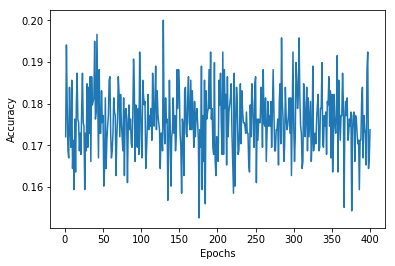

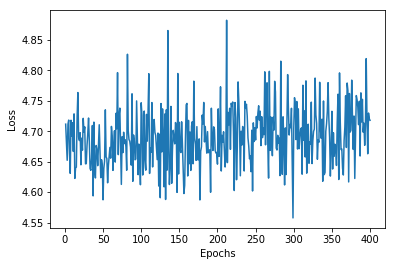

# separate nn with attention

In [115]:
class seperate_NN_attention(torch.nn.Module):

    def __init__(self,n_feature,n_hidden,n_label):
        super(seperate_NN,self).__init__()
        self.net1 = torch.nn.Sequential(
            nn.Linear(n_feature,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,n_label)            
        )
        self.net2 = torch.nn.Sequential(
            nn.Linear(n_feature,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,n_label)            
        )
        self.attention1 = 

    def forward(self,x):    # (-1,n_feature)
        y1 = self.net1(x)               
        y2 = self.net2(x)
        return y1,y2 #no need to do softmax, cross entropy will do it!
    #torch.nn.functional.softmax(y1),torch.nn.functional.softmax(y2)

use_cuda = False
model =  seperate_NN(50,20,10)
if use_cuda:
    model = model.cuda()

In [140]:
images.shape

torch.Size([16, 50])

# MLP attention

In [152]:
class MLP_feature_attention(nn.Module):
    '''
    attention with simple weight sharing
    
    '''
    def __init__(self, 
                 n_input = 50, n_hiddens = 32, n_hiddens_2 = 20,n_output = 10,):
        super(MLP_feature_attention, self).__init__()
        self.n_input = n_input
        self.n_output = n_output
        self.n_hiddens = np.atleast_1d(n_hiddens)


        layers_attention = []
        layers_attention.append(nn.Linear(n_input, n_input))
        layers_attention.append(nn.ReLU())
        layers_attention.append(nn.Linear(n_input, n_input))
        layers_attention.append(nn.Sigmoid())
        self.attention = nn.Sequential(*layers_attention)

        layers = []
        n_hidden_prev = n_input
        for n in self.n_hiddens:
            layers.append(nn.Linear(n_hidden_prev, n))
            layers.append(nn.ReLU())
            #layers.append(nn.Dropout())
            n_hidden_prev = n
        layers.append(nn.Linear(n_hidden_prev, n_hiddens_2 ))
        self.encoder = nn.Sequential(*layers)
        self.softmax = nn.Softmax(dim=n_output)
    def forward(self, x):
        x_attention = self.attention(x)
        #print (x_attention.size())
        #x_attention = torch.cat((torch.clamp(x_attention[:,:self.feature_thres_ind],
          #                                   0,self.thres_cut),
             #                    x_attention[:,self.feature_thres_ind:]),1)

        x = torch.mul(x_attention,x).view(-1,self.n_input)
        x = self.encoder(x)
        
        return x
use_cuda = False
model =  MLP_feature_attention()
if use_cuda:
    model = model.cuda()

In [153]:
def train(epoch, model, train_loader, optimizer, log_interval=100, cuda=None,report=False):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        target = target[:,:10]
        optimizer.zero_grad()
        output = model(data)

        pred = output.data.max(1)[1] # get the index of the max log-probability
        #print (output.data,output.data.max(1),output.data.size(),target.data.size())
        correct += pred.eq(target.data.max(1)[1]).cpu().sum()
        accuracy =  float(correct) / float(len(train_loader.dataset))
        #print (output, target)
        loss = torch.nn.functional.cross_entropy(output, target.max(1)[1])
        loss.backward()
        #print (loss,loss.data)
        optimizer.step()
        if batch_idx % log_interval == 0:
            if report ==1:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} Accuracy: ({:.4f})\n'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.data.item(), accuracy))

def validate(loss_vector, accuracy_vector, model, validation_loader, cuda=None,report=False):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        target = target[:,:10]
        output = model(data)
        val_loss += torch.nn.functional.cross_entropy(output, target.max(1)[1]).item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.max(1)[1]).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = float(correct) / float( len(validation_loader.dataset) )
    accuracy_vector.append(accuracy)
    if report ==1:
        print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f})\n'.format(
            val_loss, correct, len(validation_loader.dataset), accuracy))

def main(train_loader,validation_loader,LEARNING_RATES , MOMENTUM_RATES ,WEIGHT_DECAY_RATES,report_interval):
    cuda = torch.cuda.is_available()
    print('Using PyTorch version:', torch.__version__, 'CUDA:', cuda)



    hidden_nodes = 100
    layers = 1
    for i in tqdm(range(1, len(LEARNING_RATES) + 1)):
        if cuda:
            model.cuda()
        optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATES[0],momentum=MOMENTUM_RATES[0],weight_decay=WEIGHT_DECAY_RATES[0])

        loss_vector = []
        acc_vector = []
        
        for epoch in tqdm(range(1, EPOCHS + 1)):
            if epoch % report_interval ==0:
                report = 1
            else:
                report = 0 
            train(epoch, model, train_loader, optimizer, cuda=cuda,report=report)
            validate(loss_vector, acc_vector, model, validation_loader, cuda=cuda,report=report)
        # Plot train loss and validation accuracy vs epochs for each learning rate
        if PLOT:
            epochs = [i for i in range(1, 26)]
            plt.plot(np.arange(1,EPOCHS+1), acc_vector)

            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.show()

            plt.plot(np.arange(1,EPOCHS+1), loss_vector)
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.show()

Using PyTorch version: 1.0.0 CUDA: False


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=400), HTML(value='')))

Train Epoch: 10 [0/2976 (0%)]	Loss: 2.110137 Accuracy: (0.0020)

Train Epoch: 10 [2000/2976 (67%)]	Loss: 2.526560 Accuracy: (0.1680)


Validation set: Average loss: 2.2700, Accuracy: 172/1180 (0.1458)

Train Epoch: 20 [0/2976 (0%)]	Loss: 2.111789 Accuracy: (0.0013)

Train Epoch: 20 [2000/2976 (67%)]	Loss: 1.980726 Accuracy: (0.1959)


Validation set: Average loss: 2.3063, Accuracy: 203/1180 (0.1720)

Train Epoch: 30 [0/2976 (0%)]	Loss: 1.990772 Accuracy: (0.0017)

Train Epoch: 30 [2000/2976 (67%)]	Loss: 1.810527 Accuracy: (0.2060)


Validation set: Average loss: 2.2951, Accuracy: 202/1180 (0.1712)

Train Epoch: 40 [0/2976 (0%)]	Loss: 1.927070 Accuracy: (0.0013)

Train Epoch: 40 [2000/2976 (67%)]	Loss: 1.842182 Accuracy: (0.2151)


Validation set: Average loss: 2.2966, Accuracy: 205/1180 (0.1737)

Train Epoch: 50 [0/2976 (0%)]	Loss: 1.771444 Accuracy: (0.0024)

Train Epoch: 50 [2000/2976 (67%)]	Loss: 2.097174 Accuracy: (0.2261)


Validation set: Average loss: 2.3342, Accuracy: 212/1180 

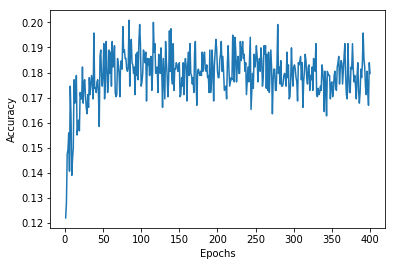

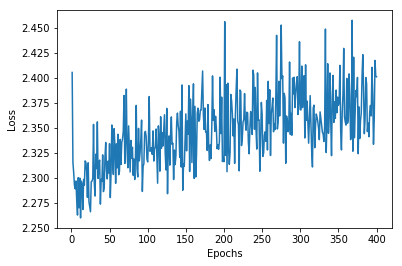

In [154]:
EPOCHS = 400
main(train_loader,test_loader,LEARNING_RATES , MOMENTUM_RATES ,WEIGHT_DECAY_RATES,report_interval = 10)

# MLP attention sample

In [155]:
class MLP_sample_attention(nn.Module):
    '''
    attention with simple weight sharing
    
    '''
    def __init__(self, 
                 n_input = 50, n_hiddens = 32, n_hiddens_2 = 20,n_output = 10,):
        super(MLP_sample_attention, self).__init__()
        self.n_input = n_input
        self.n_output = n_output
        self.n_hiddens = np.atleast_1d(n_hiddens)


        layers_attention = []
        layers_attention.append(nn.Linear(n_input, n_input))
        layers_attention.append(nn.ReLU())
        layers_attention.append(nn.Linear(n_input, 1))
        layers_attention.append(nn.Sigmoid())
        self.attention = nn.Sequential(*layers_attention)

        layers = []
        n_hidden_prev = n_input
        for n in self.n_hiddens:
            layers.append(nn.Linear(n_hidden_prev, n))
            layers.append(nn.ReLU())
            #layers.append(nn.Dropout())
            n_hidden_prev = n
        layers.append(nn.Linear(n_hidden_prev, n_hiddens_2 ))
        self.encoder = nn.Sequential(*layers)
        #self.softmax = nn.Softmax(dim=n_output)
    def forward(self, x):
        x_attention = self.attention(x)
        #print (x_attention.size())
        #x_attention = torch.cat((torch.clamp(x_attention[:,:self.feature_thres_ind],
          #                                   0,self.thres_cut),
             #                    x_attention[:,self.feature_thres_ind:]),1)

        x = torch.mul(x_attention,x).view(-1,self.n_input)
        x = self.encoder(x)
        
        return torch.nn.functional.log_softmax(x)
use_cuda = False
model =  MLP_sample_attention()
if use_cuda:
    model = model.cuda()

In [158]:
LEARNING_RATES = [0.01]
MOMENTUM_RATES = [.9]
WEIGHT_DECAY_RATES = [.005]
batch_size_train = X_train.shape[0]
batch_size_test = X_test.shape[0]
PLOT = 1
EPOCHS = 40
# Dataloader

train_data = utilsdata.TensorDataset(torch.from_numpy(X_train.astype('float32')), torch.from_numpy(y_train.astype('int')))
test_data = utilsdata.TensorDataset(torch.from_numpy(X_test.astype('float32')), torch.from_numpy(y_test.astype('int')))
train_loader = torch.utils.data.DataLoader(
                                           dataset=train_data,
                                           batch_size=batch_size_train,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(
                                          dataset=test_data,
                                          batch_size=batch_size_train,
                                          shuffle=False)


Using PyTorch version: 1.0.0 CUDA: False


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=4000), HTML(value='')))

Train Epoch: 10 [0/2976 (0%)]	Loss: 2.184390 Accuracy: (0.2285)


Validation set: Average loss: 2.2678, Accuracy: 185/1180 (0.1568)

Train Epoch: 20 [0/2976 (0%)]	Loss: 2.181597 Accuracy: (0.2292)


Validation set: Average loss: 2.2670, Accuracy: 184/1180 (0.1559)

Train Epoch: 30 [0/2976 (0%)]	Loss: 2.178323 Accuracy: (0.2305)


Validation set: Average loss: 2.2661, Accuracy: 185/1180 (0.1568)

Train Epoch: 40 [0/2976 (0%)]	Loss: 2.174923 Accuracy: (0.2312)


Validation set: Average loss: 2.2651, Accuracy: 185/1180 (0.1568)

Train Epoch: 50 [0/2976 (0%)]	Loss: 2.171531 Accuracy: (0.2312)


Validation set: Average loss: 2.2642, Accuracy: 187/1180 (0.1585)

Train Epoch: 60 [0/2976 (0%)]	Loss: 2.168193 Accuracy: (0.2298)


Validation set: Average loss: 2.2634, Accuracy: 191/1180 (0.1619)

Train Epoch: 70 [0/2976 (0%)]	Loss: 2.164914 Accuracy: (0.2319)


Validation set: Average loss: 2.2625, Accuracy: 191/1180 (0.1619)

Train Epoch: 80 [0/2976 (0%)]	Loss: 2.161720 Accuracy: (0.2319)


Val

Train Epoch: 630 [0/2976 (0%)]	Loss: 2.040076 Accuracy: (0.2856)


Validation set: Average loss: 2.2615, Accuracy: 209/1180 (0.1771)

Train Epoch: 640 [0/2976 (0%)]	Loss: 2.038406 Accuracy: (0.2870)


Validation set: Average loss: 2.2619, Accuracy: 211/1180 (0.1788)

Train Epoch: 650 [0/2976 (0%)]	Loss: 2.036748 Accuracy: (0.2883)


Validation set: Average loss: 2.2622, Accuracy: 209/1180 (0.1771)

Train Epoch: 660 [0/2976 (0%)]	Loss: 2.035102 Accuracy: (0.2890)


Validation set: Average loss: 2.2627, Accuracy: 209/1180 (0.1771)

Train Epoch: 670 [0/2976 (0%)]	Loss: 2.033469 Accuracy: (0.2893)


Validation set: Average loss: 2.2630, Accuracy: 209/1180 (0.1771)

Train Epoch: 680 [0/2976 (0%)]	Loss: 2.031862 Accuracy: (0.2917)


Validation set: Average loss: 2.2634, Accuracy: 206/1180 (0.1746)

Train Epoch: 690 [0/2976 (0%)]	Loss: 2.030262 Accuracy: (0.2920)


Validation set: Average loss: 2.2639, Accuracy: 208/1180 (0.1763)

Train Epoch: 700 [0/2976 (0%)]	Loss: 2.028688 Accuracy: (0.292

Train Epoch: 1240 [0/2976 (0%)]	Loss: 1.961347 Accuracy: (0.3101)


Validation set: Average loss: 2.2907, Accuracy: 205/1180 (0.1737)

Train Epoch: 1250 [0/2976 (0%)]	Loss: 1.960372 Accuracy: (0.3115)


Validation set: Average loss: 2.2911, Accuracy: 206/1180 (0.1746)

Train Epoch: 1260 [0/2976 (0%)]	Loss: 1.959411 Accuracy: (0.3115)


Validation set: Average loss: 2.2916, Accuracy: 208/1180 (0.1763)

Train Epoch: 1270 [0/2976 (0%)]	Loss: 1.958453 Accuracy: (0.3122)


Validation set: Average loss: 2.2920, Accuracy: 209/1180 (0.1771)

Train Epoch: 1280 [0/2976 (0%)]	Loss: 1.957503 Accuracy: (0.3132)


Validation set: Average loss: 2.2924, Accuracy: 211/1180 (0.1788)

Train Epoch: 1290 [0/2976 (0%)]	Loss: 1.956556 Accuracy: (0.3142)


Validation set: Average loss: 2.2929, Accuracy: 211/1180 (0.1788)

Train Epoch: 1300 [0/2976 (0%)]	Loss: 1.955618 Accuracy: (0.3149)


Validation set: Average loss: 2.2933, Accuracy: 212/1180 (0.1797)

Train Epoch: 1310 [0/2976 (0%)]	Loss: 1.954687 Accuracy

Train Epoch: 1850 [0/2976 (0%)]	Loss: 1.913256 Accuracy: (0.3337)


Validation set: Average loss: 2.3148, Accuracy: 215/1180 (0.1822)

Train Epoch: 1860 [0/2976 (0%)]	Loss: 1.912628 Accuracy: (0.3340)


Validation set: Average loss: 2.3151, Accuracy: 215/1180 (0.1822)

Train Epoch: 1870 [0/2976 (0%)]	Loss: 1.912006 Accuracy: (0.3337)


Validation set: Average loss: 2.3154, Accuracy: 215/1180 (0.1822)

Train Epoch: 1880 [0/2976 (0%)]	Loss: 1.911388 Accuracy: (0.3340)


Validation set: Average loss: 2.3157, Accuracy: 215/1180 (0.1822)

Train Epoch: 1890 [0/2976 (0%)]	Loss: 1.910774 Accuracy: (0.3353)


Validation set: Average loss: 2.3160, Accuracy: 216/1180 (0.1831)

Train Epoch: 1900 [0/2976 (0%)]	Loss: 1.910170 Accuracy: (0.3350)


Validation set: Average loss: 2.3164, Accuracy: 216/1180 (0.1831)

Train Epoch: 1910 [0/2976 (0%)]	Loss: 1.909566 Accuracy: (0.3360)


Validation set: Average loss: 2.3166, Accuracy: 215/1180 (0.1822)

Train Epoch: 1920 [0/2976 (0%)]	Loss: 1.908968 Accuracy

Train Epoch: 2460 [0/2976 (0%)]	Loss: 1.881315 Accuracy: (0.3495)


Validation set: Average loss: 2.3296, Accuracy: 209/1180 (0.1771)

Train Epoch: 2470 [0/2976 (0%)]	Loss: 1.880875 Accuracy: (0.3495)


Validation set: Average loss: 2.3298, Accuracy: 209/1180 (0.1771)

Train Epoch: 2480 [0/2976 (0%)]	Loss: 1.880440 Accuracy: (0.3498)


Validation set: Average loss: 2.3300, Accuracy: 209/1180 (0.1771)

Train Epoch: 2490 [0/2976 (0%)]	Loss: 1.880004 Accuracy: (0.3498)


Validation set: Average loss: 2.3301, Accuracy: 207/1180 (0.1754)

Train Epoch: 2500 [0/2976 (0%)]	Loss: 1.879569 Accuracy: (0.3501)


Validation set: Average loss: 2.3303, Accuracy: 207/1180 (0.1754)

Train Epoch: 2510 [0/2976 (0%)]	Loss: 1.879137 Accuracy: (0.3498)


Validation set: Average loss: 2.3304, Accuracy: 206/1180 (0.1746)

Train Epoch: 2520 [0/2976 (0%)]	Loss: 1.878708 Accuracy: (0.3501)


Validation set: Average loss: 2.3305, Accuracy: 206/1180 (0.1746)

Train Epoch: 2530 [0/2976 (0%)]	Loss: 1.878285 Accuracy

Train Epoch: 3070 [0/2976 (0%)]	Loss: 1.858667 Accuracy: (0.3535)


Validation set: Average loss: 2.3373, Accuracy: 209/1180 (0.1771)

Train Epoch: 3080 [0/2976 (0%)]	Loss: 1.858354 Accuracy: (0.3538)


Validation set: Average loss: 2.3374, Accuracy: 208/1180 (0.1763)

Train Epoch: 3090 [0/2976 (0%)]	Loss: 1.858048 Accuracy: (0.3535)


Validation set: Average loss: 2.3375, Accuracy: 208/1180 (0.1763)

Train Epoch: 3100 [0/2976 (0%)]	Loss: 1.857741 Accuracy: (0.3538)


Validation set: Average loss: 2.3376, Accuracy: 208/1180 (0.1763)

Train Epoch: 3110 [0/2976 (0%)]	Loss: 1.857430 Accuracy: (0.3542)


Validation set: Average loss: 2.3377, Accuracy: 208/1180 (0.1763)

Train Epoch: 3120 [0/2976 (0%)]	Loss: 1.857127 Accuracy: (0.3538)


Validation set: Average loss: 2.3379, Accuracy: 208/1180 (0.1763)

Train Epoch: 3130 [0/2976 (0%)]	Loss: 1.856819 Accuracy: (0.3535)


Validation set: Average loss: 2.3380, Accuracy: 208/1180 (0.1763)

Train Epoch: 3140 [0/2976 (0%)]	Loss: 1.856520 Accuracy

Train Epoch: 3680 [0/2976 (0%)]	Loss: 1.842613 Accuracy: (0.3572)


Validation set: Average loss: 2.3425, Accuracy: 212/1180 (0.1797)

Train Epoch: 3690 [0/2976 (0%)]	Loss: 1.842384 Accuracy: (0.3575)


Validation set: Average loss: 2.3425, Accuracy: 211/1180 (0.1788)

Train Epoch: 3700 [0/2976 (0%)]	Loss: 1.842163 Accuracy: (0.3575)


Validation set: Average loss: 2.3425, Accuracy: 211/1180 (0.1788)

Train Epoch: 3710 [0/2976 (0%)]	Loss: 1.841939 Accuracy: (0.3579)


Validation set: Average loss: 2.3426, Accuracy: 212/1180 (0.1797)

Train Epoch: 3720 [0/2976 (0%)]	Loss: 1.841716 Accuracy: (0.3582)


Validation set: Average loss: 2.3426, Accuracy: 211/1180 (0.1788)

Train Epoch: 3730 [0/2976 (0%)]	Loss: 1.841495 Accuracy: (0.3582)


Validation set: Average loss: 2.3426, Accuracy: 211/1180 (0.1788)

Train Epoch: 3740 [0/2976 (0%)]	Loss: 1.841273 Accuracy: (0.3582)


Validation set: Average loss: 2.3426, Accuracy: 211/1180 (0.1788)

Train Epoch: 3750 [0/2976 (0%)]	Loss: 1.841054 Accuracy

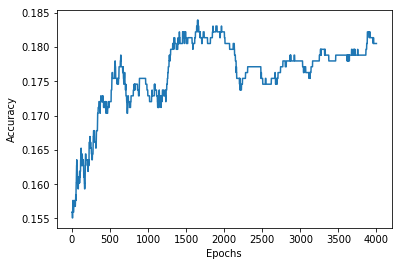

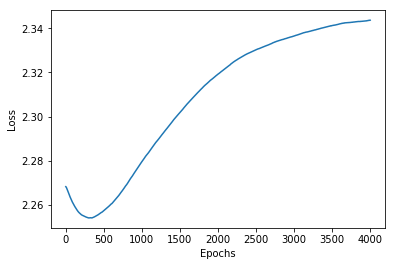

In [161]:
EPOCHS = 4000
main(train_loader,test_loader,LEARNING_RATES , MOMENTUM_RATES ,WEIGHT_DECAY_RATES,report_interval = 10)

# one model predict context and label with attention
最后forward的时候接出来两个不同的linear

In [163]:
class joint_NN(torch.nn.Module):

    def __init__(self,n_feature,n_hidden,n_label):
        super(joint_NN,self).__init__()
        self.net = torch.nn.Sequential(
            nn.Linear(n_feature,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,n_label)            
        )
        self.linear1 = torch.nn.Sequential(
            nn.Linear(n_label,n_label),
            nn.ReLU(),         
        )
        self.linear2 = torch.nn.Sequential(
            nn.Linear(n_label,n_label),
            nn.ReLU(),         
        )

    def forward(self,x):    # (-1,n_feature)
        y = self.net(x) 
        y1 = self.linear1(y)
        y2 = self.linear2(y)
        return y1,y2 #no need to do softmax, cross entropy will do it!
    #torch.nn.functional.softmax(y1),torch.nn.functional.softmax(y2)

use_cuda = False
model =  joint_NN(50,20,10)
if use_cuda:
    model = model.cuda()

Using PyTorch version: 1.0.0 CUDA: False


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Train Epoch: 10 [0/2976 (0%)]	Loss: 4.596283 Accuracy: (0.1300)


Validation set: Average loss: 4.5773, Accuracy: 146/1180 (0.1237)

Train Epoch: 20 [0/2976 (0%)]	Loss: 4.592123 Accuracy: (0.1324)


Validation set: Average loss: 4.5786, Accuracy: 150/1180 (0.1271)

Train Epoch: 30 [0/2976 (0%)]	Loss: 4.586774 Accuracy: (0.1391)


Validation set: Average loss: 4.5823, Accuracy: 148/1180 (0.1254)

Train Epoch: 40 [0/2976 (0%)]	Loss: 4.581976 Accuracy: (0.1421)


Validation set: Average loss: 4.5869, Accuracy: 148/1180 (0.1254)

Train Epoch: 50 [0/2976 (0%)]	Loss: 4.577864 Accuracy: (0.1418)


Validation set: Average loss: 4.5911, Accuracy: 150/1180 (0.1271)

Train Epoch: 60 [0/2976 (0%)]	Loss: 4.574296 Accuracy: (0.1438)


Validation set: Average loss: 4.5952, Accuracy: 158/1180 (0.1339)

Train Epoch: 70 [0/2976 (0%)]	Loss: 4.570862 Accuracy: (0.1448)


Validation set: Average loss: 4.6000, Accuracy: 156/1180 (0.1322)

Train Epoch: 80 [0/2976 (0%)]	Loss: 4.567360 Accuracy: (0.1468)


Val

Train Epoch: 630 [0/2976 (0%)]	Loss: 4.438091 Accuracy: (0.2036)


Validation set: Average loss: 4.6175, Accuracy: 190/1180 (0.1610)

Train Epoch: 640 [0/2976 (0%)]	Loss: 4.434966 Accuracy: (0.2033)


Validation set: Average loss: 4.6166, Accuracy: 189/1180 (0.1602)

Train Epoch: 650 [0/2976 (0%)]	Loss: 4.431780 Accuracy: (0.2043)


Validation set: Average loss: 4.6155, Accuracy: 192/1180 (0.1627)

Train Epoch: 660 [0/2976 (0%)]	Loss: 4.428420 Accuracy: (0.2077)


Validation set: Average loss: 4.6143, Accuracy: 192/1180 (0.1627)

Train Epoch: 670 [0/2976 (0%)]	Loss: 4.424176 Accuracy: (0.2100)


Validation set: Average loss: 4.6126, Accuracy: 190/1180 (0.1610)

Train Epoch: 680 [0/2976 (0%)]	Loss: 4.419258 Accuracy: (0.2110)


Validation set: Average loss: 4.6107, Accuracy: 186/1180 (0.1576)

Train Epoch: 690 [0/2976 (0%)]	Loss: 4.414603 Accuracy: (0.2124)


Validation set: Average loss: 4.6086, Accuracy: 188/1180 (0.1593)

Train Epoch: 700 [0/2976 (0%)]	Loss: 4.410140 Accuracy: (0.214

Train Epoch: 1240 [0/2976 (0%)]	Loss: 4.155591 Accuracy: (0.2621)


Validation set: Average loss: 4.5992, Accuracy: 194/1180 (0.1644)

Train Epoch: 1250 [0/2976 (0%)]	Loss: 4.152606 Accuracy: (0.2628)


Validation set: Average loss: 4.5998, Accuracy: 193/1180 (0.1636)

Train Epoch: 1260 [0/2976 (0%)]	Loss: 4.149652 Accuracy: (0.2641)


Validation set: Average loss: 4.6006, Accuracy: 194/1180 (0.1644)

Train Epoch: 1270 [0/2976 (0%)]	Loss: 4.146716 Accuracy: (0.2644)


Validation set: Average loss: 4.6012, Accuracy: 193/1180 (0.1636)

Train Epoch: 1280 [0/2976 (0%)]	Loss: 4.143827 Accuracy: (0.2651)


Validation set: Average loss: 4.6016, Accuracy: 193/1180 (0.1636)

Train Epoch: 1290 [0/2976 (0%)]	Loss: 4.140993 Accuracy: (0.2651)


Validation set: Average loss: 4.6023, Accuracy: 193/1180 (0.1636)

Train Epoch: 1300 [0/2976 (0%)]	Loss: 4.138207 Accuracy: (0.2651)


Validation set: Average loss: 4.6028, Accuracy: 194/1180 (0.1644)

Train Epoch: 1310 [0/2976 (0%)]	Loss: 4.135468 Accuracy

Train Epoch: 1850 [0/2976 (0%)]	Loss: 4.030933 Accuracy: (0.2967)


Validation set: Average loss: 4.6454, Accuracy: 192/1180 (0.1627)

Train Epoch: 1860 [0/2976 (0%)]	Loss: 4.029368 Accuracy: (0.2964)


Validation set: Average loss: 4.6468, Accuracy: 193/1180 (0.1636)

Train Epoch: 1870 [0/2976 (0%)]	Loss: 4.027837 Accuracy: (0.2984)


Validation set: Average loss: 4.6476, Accuracy: 193/1180 (0.1636)

Train Epoch: 1880 [0/2976 (0%)]	Loss: 4.026333 Accuracy: (0.2987)


Validation set: Average loss: 4.6492, Accuracy: 193/1180 (0.1636)

Train Epoch: 1890 [0/2976 (0%)]	Loss: 4.024857 Accuracy: (0.2987)


Validation set: Average loss: 4.6506, Accuracy: 194/1180 (0.1644)

Train Epoch: 1900 [0/2976 (0%)]	Loss: 4.023408 Accuracy: (0.2991)


Validation set: Average loss: 4.6515, Accuracy: 195/1180 (0.1653)

Train Epoch: 1910 [0/2976 (0%)]	Loss: 4.021978 Accuracy: (0.2987)


Validation set: Average loss: 4.6526, Accuracy: 195/1180 (0.1653)

Train Epoch: 1920 [0/2976 (0%)]	Loss: 4.020566 Accuracy

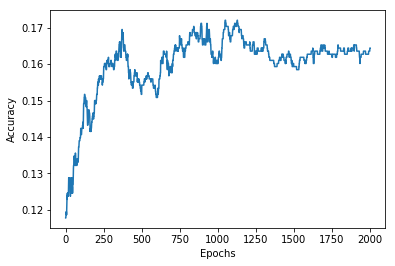

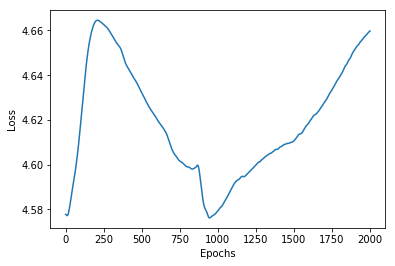

In [165]:
def train(epoch, model, train_loader, optimizer, log_interval=100, cuda=None,report=False):
    model.train()
    correct1 = 0
    correct2 = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        target1 = target[:,:10]
        target2 = target[:,10:]
        data, target1, target2 = Variable(data), Variable(target1), Variable(target2)
        optimizer.zero_grad()
        output1, output2 = model(data) #return y1 and y2 for class and context

        pred1 = output1.data.max(1)[1] # get the index of the max log-probability
        pred2 = output2.data.max(1)[1]
        #print (output.data,output.data.max(1),output.data.size(),target.data.size())
        #print (target2)
        #print (pred2.eq(target2.data.max(1)[1]).cpu().sum())
        correct1 += pred1.eq(target1.data.max(1)[1]).cpu().sum()
        correct2 += pred2.eq(target2.data.max(1)[1]).cpu().sum()
        accuracy1 =  float(correct1) / float(len(train_loader.dataset))
        accuracy2 =  float(correct2) / float(len(train_loader.dataset))
        #print (output1.max(1)[1],target1.max(1)[1])
        loss = torch.nn.functional.cross_entropy(output1, target1.max(1)[1]) +torch.nn.functional.cross_entropy(output2, target2.max(1)[1])
        loss.backward()
        #print (loss,loss.data)
        optimizer.step()
        if batch_idx % log_interval == 0:
            if report ==1:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} Accuracy: ({:.4f})\n'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.data.item(), accuracy1))

def validate(loss_vector, accuracy_vector, model, validation_loader, cuda=None,report=False):
    model.eval()
    val_loss, correct1,correct2 = 0, 0,0
    for data, target in validation_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        target1 = target[:,:10]
        target2 = target[:,10:]
        data, target1, target2 = Variable(data, volatile=True), Variable(target1), Variable(target2)
        output1, output2 = model(data)
        val_loss += torch.nn.functional.cross_entropy(output1, target1.max(1)[1]).item()+torch.nn.functional.cross_entropy(output2, target2.max(1)[1]).item()
        pred1 = output1.data.max(1)[1] # get the index of the max log-probability
        pred2 = output2.data.max(1)[1]
        #correct += pred.eq(target.data).cpu().sum()
        #print (pred1,target1)
        correct1 += pred1.eq(target1.data.max(1)[1]).cpu().sum()
        correct2 += pred2.eq(target2.data.max(1)[1]).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy1 = float(correct1) / float( len(validation_loader.dataset) )
    accuracy2 = float(correct2) / float( len(validation_loader.dataset) )
    accuracy_vector.append(accuracy1)
    if report ==1:
        print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f})\n'.format(
            val_loss, correct1, len(validation_loader.dataset), accuracy1))
def main(train_loader,validation_loader,LEARNING_RATES , MOMENTUM_RATES ,WEIGHT_DECAY_RATES,report_interval):
    cuda = torch.cuda.is_available()
    print('Using PyTorch version:', torch.__version__, 'CUDA:', cuda)



    for i in tqdm(range(1, len(LEARNING_RATES) + 1)):
        if cuda:
            model.cuda()
        optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATES[0],momentum=MOMENTUM_RATES[0],weight_decay=WEIGHT_DECAY_RATES[0])

        loss_vector = []
        acc_vector = []
        
        for epoch in tqdm(range(1, EPOCHS + 1)):
            if epoch % report_interval ==0:
                report = 1
            else:
                report = 0 
            train(epoch, model, train_loader, optimizer, cuda=cuda,report=report)
            validate(loss_vector, acc_vector, model, validation_loader, cuda=cuda,report=report)
        # Plot train loss and validation accuracy vs epochs for each learning rate
        if PLOT:
            epochs = [i for i in range(1, 26)]
            plt.plot(np.arange(1,EPOCHS+1), acc_vector)

            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.show()

            plt.plot(np.arange(1,EPOCHS+1), loss_vector)
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.show()
            
EPOCHS = 2000
main(train_loader,test_loader,LEARNING_RATES , MOMENTUM_RATES ,WEIGHT_DECAY_RATES,report_interval = 10)

# joint nn attention
- feature
- sample

# MDN

# Mixed Ridge

# RUV treated matrix as input
then + ML or MLP?

In [121]:
io.loadmat('data/test_feature.mat')['feature'].shape

(1200, 50)